In [1]:
import sys
sys.path.append('../')
from lattice import *
import numpy as np
import matplotlib.pyplot as plt
import pickle
import lattice.animation_utils as lanim
import os
import pandas as pd
import pyperclip

# Redo plot with P_orb^bulk instead of P_orb

In [2]:
def ohc_bulk(K, L, J, A_tot, geometry):
    m = 0.741
    a_NN = 1 # TODO
    P = np.zeros(2)
    w = -23/12 * m / A_tot
    R = np.array([[0, -1], [1, 0]])

    for (k, l, j) in zip(K, L, J, strict=True):
        r_k, r_l = np.array(geometry.site_to_position(k)), np.array(geometry.site_to_position(l))
        P += w * j * (R @ (r_l - r_k))
    return P

In [ ]:
# Calc P_bulk OHCs to test whether alternative polarisation definition changes results 

colors = {0.5: "blue", 1: "orange", 2: "green"}
rows = []
for fn in os.listdir("data_final"):
    if fn.endswith(".pkl"):
        with open(f"data_final/{fn}", "rb") as f:
            d = pickle.load(f)

        if d["substeps"] < 150: continue
        if d["Lx"] > 29: continue

        geometry = HexagonalLatticeGeometry((d["Lx"], d["Ly"]))
        edges = np.array(geometry.edges)
        K, L = edges[:,0], edges[:,1]
        A_tot = len(geometry.get_curl_sites()) * np.sqrt(3) * 3/2

        bulk_pols = np.array([ohc_bulk(K, L, J, A_tot, geometry)for J in d["animation_values"]["bond_currents"]])
        m = np.argmax(bulk_pols[:, 0])

        # # check total OAM vanishes
        # s = np.sum(d["animation_values"]["orbital_curl"], axis = 1)
        # plt.plot(s)
        # plt.show()

        rows.append({
        "Lx": d.get("Lx"),
        "Ly": d.get("Ly"),
        "omega": d.get("omega"),
        "ohc_abs": 2 * np.pi * bulk_pols[m, 0] / 1e-3,
        "ohc_angle": m,
    })

ohc_df = pd.DataFrame(rows).sort_values(["omega", "Lx", "Ly"], ignore_index=True)

In [8]:
ohc_df.head()

,Lx,Ly,omega,ohc_abs,ohc_angle
0,11,20,0.5,0.747198,6
1,11,40,0.5,0.515148,6
2,11,80,0.5,0.458516,6
3,19,20,0.5,1.462013,6
4,19,40,0.5,1.330354,6


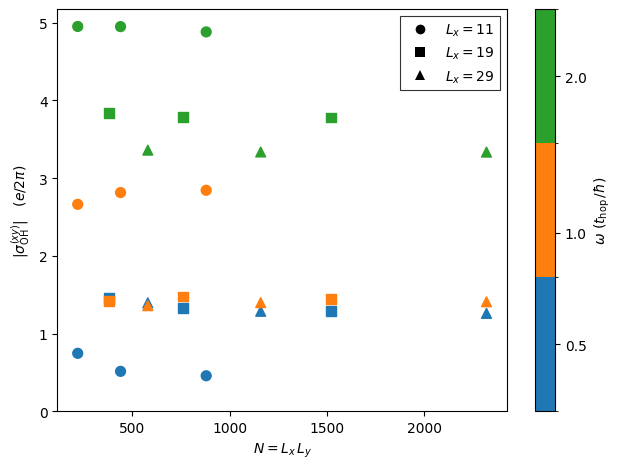

In [ ]:
from matplotlib.colors import BoundaryNorm
from matplotlib.cm import ScalarMappable

omegas = np.sort(ohc_df["omega"].unique())
N = len(omegas)

cmap = plt.get_cmap("tab10", 3*N)
if N == 1:
    bounds = np.array([omegas[0] - 0.1, omegas[0] + 0.1])
else:
    mids = (omegas[:-1] + omegas[1:]) / 2
    first = omegas[0] - (mids[0] - omegas[0])
    last = omegas[-1] + (omegas[-1] - mids[-1])
    bounds = np.concatenate(([first], mids, [last]))
norm = BoundaryNorm(bounds, N)

sm = ScalarMappable(norm=norm, cmap=cmap)
sm.set_array([])

fig = plt.gcf()

cb = fig.colorbar(sm, ax=plt.gca(), ticks=omegas)
cb.ax.set_yticklabels([str(o) for o in omegas])
cb.set_label("$\\omega\\ (t_\\mathrm{hop}\\,/\\hbar)$")

# plot ohc_abs vs system size (Lx*Ly), with markers based on Lx and colors based on omega
markers = ['o', 's', '^']
colors = plt.cm.viridis(np.linspace(0, 1, len(ohc_df["Ly"].unique())))

for i, lx in enumerate(sorted(ohc_df["Lx"].unique())):
    lx_data = ohc_df[ohc_df["Lx"] == lx]
    plt.scatter(
        lx_data["Ly"] * lx_data["Lx"],
        lx_data["ohc_abs"],
        marker=markers[i],
        c=lx_data["omega"],
        s=50,
        label=f'Lx={lx}',
        cmap=cmap,
        norm=norm,
        alpha=1
    )

import matplotlib.lines as mlines

s = mlines.Line2D([], [], color='black', marker='s', ls='', label='$L_x=19$', markeredgewidth=0, markersize=7)
o = mlines.Line2D([], [], color='black', marker='o', ls='', label='$L_x=11$', markeredgewidth=0, markersize=7)
v = mlines.Line2D([], [], color='black', marker='^', ls='', label='$L_x=29$', markeredgewidth=0, markersize=7)

legend = plt.legend(handles=[o,s, v], fancybox=False, edgecolor='black')
legend.get_frame().set_linewidth(0.8)

plt.ylim(bottom=0)
plt.xlabel("$N=L_x\\, L_y$")
plt.ylabel("$|\\sigma_\\mathrm{OH}^{(xy)}| \\quad (e/2\\pi)$")
plt.tight_layout()
plt.show()

# Spectrum

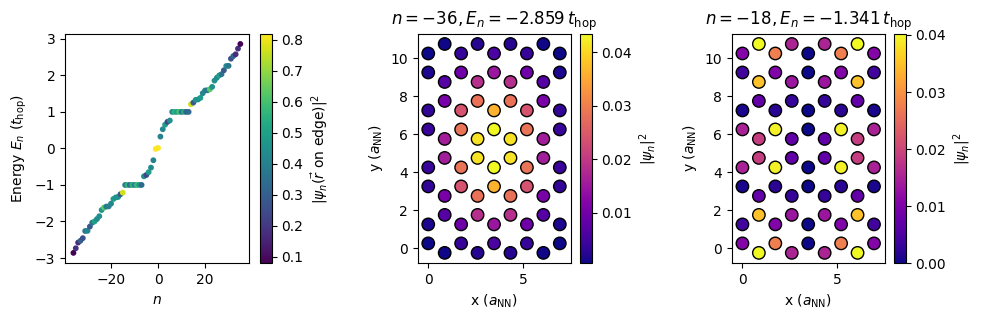

In [ ]:
Lx, Ly = 9, 8
geometry = HexagonalLatticeGeometry((Lx, Ly))

H = geometry.get_hopping_matrix(-1)
E, psi = np.linalg.eigh(H)

# Edge indices
indices = np.arange(Lx * Ly)
x = indices % Lx
y = indices // Lx

edge_mask = (x == 0) | (x == Lx - 1) | (y == 0) | (y == Ly - 1)
edge_weight = np.sum(np.abs(psi[edge_mask, :]) ** 2, axis=0)

off = len(E) // 2

# Pick bulk and edge state
bulk_state = 0
edge_state = 18

fig, axs = plt.subplots(1, 3, figsize=(10, 3.3), width_ratios=[1.2, 1, 1])

# Spectrum
sc = axs[0].scatter(np.arange(-off, off), E, c=edge_weight, cmap="viridis", s=40, marker = ".")
#axs[0].scatter([bulk_state, edge_state], [E[bulk_state], E[edge_state]], c=['b', 'r'], s=50, label="selected")
axs[0].set_xlabel("$n$")
axs[0].set_ylabel("Energy $E_n\\ (t_\\mathrm{hop})$")
#axs[0].set_title("Eigenvalue Spectrum")
# axs[0].grid(True, alpha=0.3)
fig.colorbar(sc, ax=axs[0], label="$|\\psi_n(\\vec r \\text{ on edge})|^2$")

# Positions
positions = np.array([geometry.site_to_position(i) for i in range(Lx * Ly)])
xpos, ypos = positions[:, 0], positions[:, 1]

# Bulk state plot
axs[1].scatter(xpos, ypos, c=np.abs(psi[:, bulk_state]) ** 2, cmap="plasma", s=80, edgecolors='k')
axs[1].set_title(f"$n={bulk_state-off}, E_n={E[bulk_state]:.3f}\\,t_\\mathrm{{hop}}$")
axs[1].axis('equal')
axs[1].set_xlabel('x $(a_\\mathrm{NN})$')
axs[1].set_ylabel('y $(a_\\mathrm{NN})$')
fig.colorbar(axs[1].collections[0], ax=axs[1], label=r'$|\psi_n|^2$')

# Edge state plot
axs[2].scatter(xpos, ypos, c=np.abs(psi[:, edge_state]) ** 2, cmap="plasma", s=80, edgecolors='k')
axs[2].set_title(f"$n={edge_state-off}, E_n={E[edge_state]:.3f}\\,t_\\mathrm{{hop}}$")
axs[2].axis('equal')
axs[2].set_xlabel('x $(a_\\mathrm{NN})$')
axs[2].set_ylabel('y $(a_\\mathrm{NN})$')
fig.colorbar(axs[2].collections[0], ax=axs[2], label=r'$|\psi_n|^2$')

plt.tight_layout()
plt.savefig("spectrum.pdf")
plt.show()


# Animations

In [2]:
for fn in os.listdir("data_final"):
    if fn.endswith(".pkl"):
        with open(f"data_final/{fn}", "rb") as f:
            d = pickle.load(f)

        if d["substeps"] < 150: continue

        omega = d["omega"]
        T = 2 * np.pi / omega

        cycles = 17
        T_ramp = 3 * 2 * np.pi / 0.5
        # start_index=((cycles-1)*T + T_ramp) / (l.h/substeps),
        start_index=((cycles-1)*T + T_ramp) / (d["h"]/d["substeps"])
        steps = T/(d["h"]/d["substeps"])
        indices = np.arange(start_index, start_index + steps, steps // 20)
        indices = np.astype(indices / (d["substeps"] // 25), int)
        assert len(d["animation_values"]["bond_currents"]) == len(indices)


        E_time = d["E_time"]
        E_amplitude = d["E_amplitude"]
        orb_pol_values = d["orb_pol_values"]
        frame_texts = [
            f"$t={E_time[i]:.1f}$ \t $E^{{(y)}}(t)={E_amplitude[i] * 1000 :.2f} \\times 10^{{-3}}$ \t $\\langle P_{{orb}}^{{(x)}}(t)\\rangle={orb_pol_values[i][0] * 1000:.3f} \\times 10^{{-3}}$"
            for i in indices
        ]

        geometry = HexagonalLatticeGeometry((d["Lx"], d["Ly"]))
        E = np.array(geometry.edges)
        lanim.save_current_density_animation(
            geometry, 
            d["animation_values"], 
            E[:,0], E[:,1],
            f"animations/{fn[:-4]}.mp4",
            fps=3,
            dpi=80,
            show_flow_arrows=True,
            show_curl_indicators=True,
            show_curl_direction_arrows=True,
            site_marker_size=200,
            arrow_width=0.05,
            frame_texts=frame_texts,
        )

## HQ animations for frames

In [4]:
anim_args = []
anim_kwargs = []

max_current = 0
max_curl = 0

for fn in os.listdir("data_final"):
    if not fn.endswith(".pkl"): continue

    with open(f"data_final/{fn}", "rb") as f:
        d = pickle.load(f)

    if d["substeps"] < 150: continue

    omega = d["omega"]
    if  d["Ly"] != 20 or d["Lx"] != 19 or omega != 1: continue

    T = 2 * np.pi / omega

    cycles = 17
    T_ramp = 3 * 2 * np.pi / 0.5
    # start_index=((cycles-1)*T + T_ramp) / (l.h/substeps),
    start_index=((cycles-1)*T + T_ramp) / (d["h"]/d["substeps"])
    steps = T/(d["h"]/d["substeps"])
    indices = np.arange(start_index, start_index + steps, steps // 20)
    indices = np.astype(indices / (d["substeps"] // 25), int)
    assert len(d["animation_values"]["bond_currents"]) == len(indices)


    E_time = d["E_time"]
    E_amplitude = d["E_amplitude"]
    orb_pol_values = d["orb_pol_values"]
    frame_texts = [
        f"$t={E_time[i]:.1f}$ \t $E^{{(y)}}(t)={E_amplitude[i] * 1000 :.2f} \\times 10^{{-3}}$ \t $\\langle P_{{orb}}^{{(x)}}(t)\\rangle={orb_pol_values[i][0] * 1000:.3f} \\times 10^{{-3}}$"
        for i in indices
    ]

    geometry = HexagonalLatticeGeometry((d["Lx"], d["Ly"]))
    E = np.array(geometry.edges)

    max_current = max(max_current, np.max(np.abs(d["animation_values"]["bond_currents"])))
    max_curl = max(max_curl, np.max(np.abs(d["animation_values"]["orbital_curl"])))

    anim_args.append([
        geometry, 
        d["animation_values"], 
        E[:,0], E[:,1],
        f"animations_hq/{fn[:-4]}.mp4",
    ])

    anim_kwargs.append({
        "fps":3,
        "dpi":200,
        "show_flow_arrows":True,
        "show_curl_indicators":True,
        "show_curl_direction_arrows":True,
        "site_marker_size":200,
        "arrow_width":0.05,
        "frame_texts":frame_texts,
    })


for anim_arg, anim_kwarg in zip(anim_args, anim_kwargs):
    lanim.save_current_density_animation(
        *anim_arg,
        **anim_kwarg,
        current_max=max_current,
        curl_vmax=max_curl,
    )

# OHCs

In [2]:
def fourier_at_omega(signal, dt, omega):
    N = len(signal)
    n = np.arange(N)
    t = n * dt
    phase = np.exp(-1j * omega * t)
    return np.sum(signal * phase) * dt

def ohc(data, t_eq):
    dt = np.diff(data["E_time"]).mean() # here
    orb_current_values = np.diff(data["orb_pol_values"][-t_eq-1:,0]) / dt
    return 2 * np.pi * fourier_at_omega(orb_current_values, dt, data["omega"]) / fourier_at_omega(data["E_amplitude"][-t_eq:], dt, data["omega"])

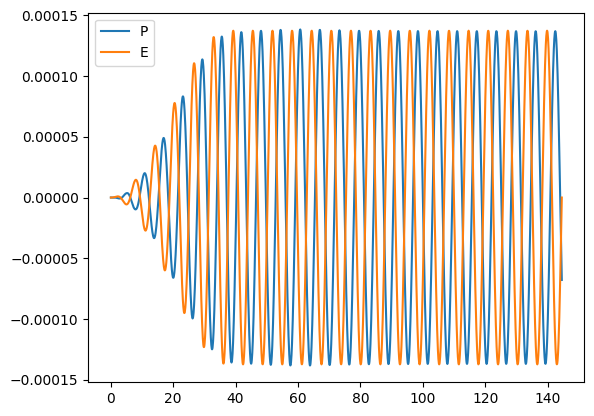

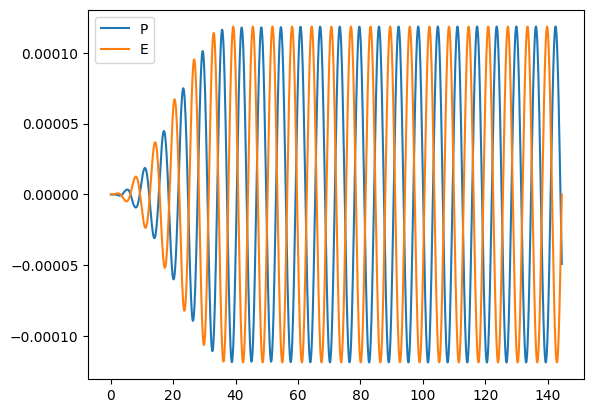

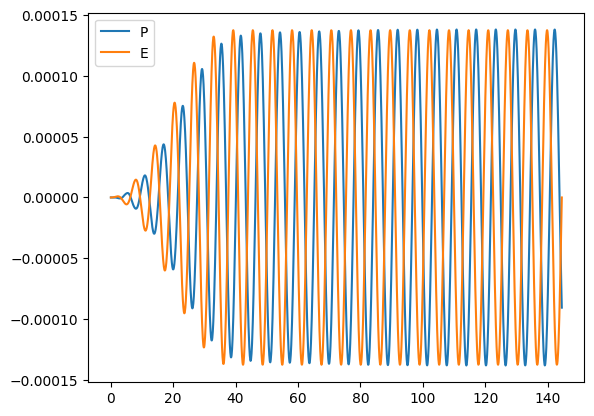

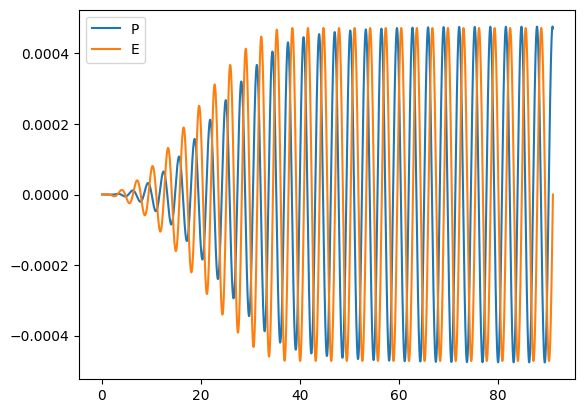

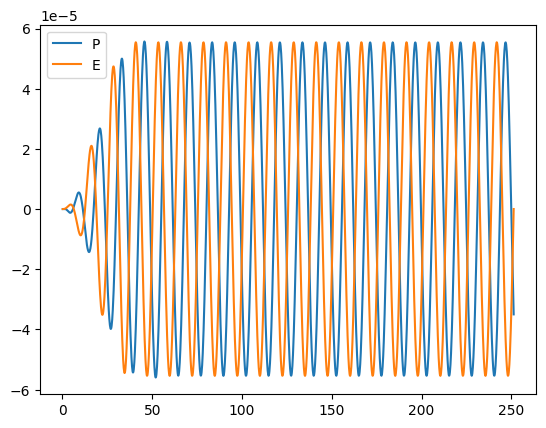

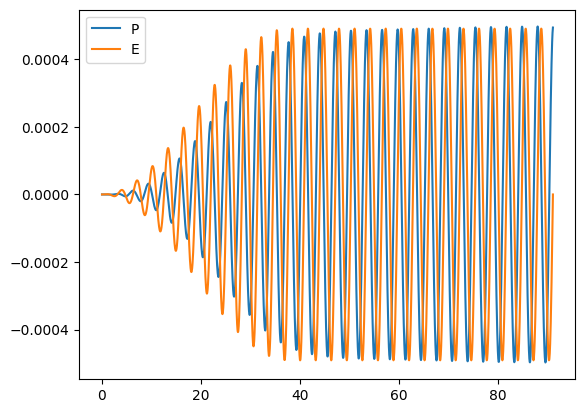

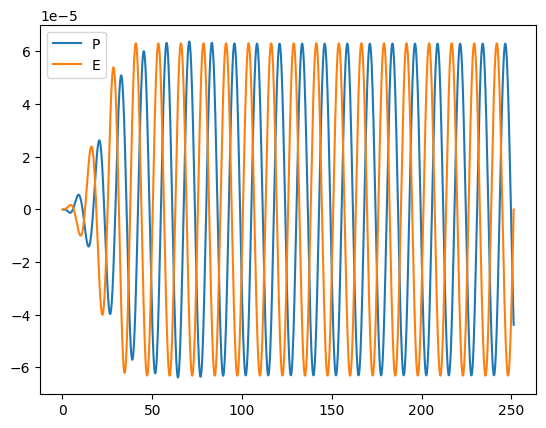

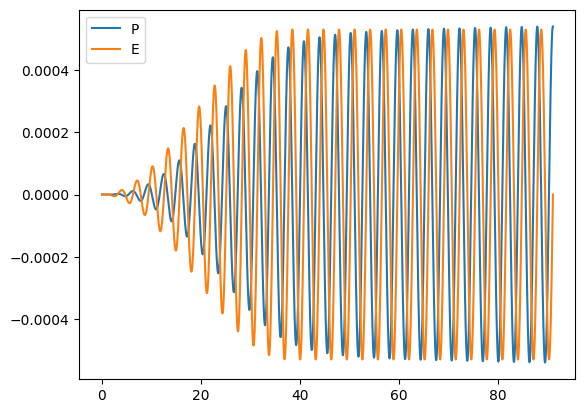

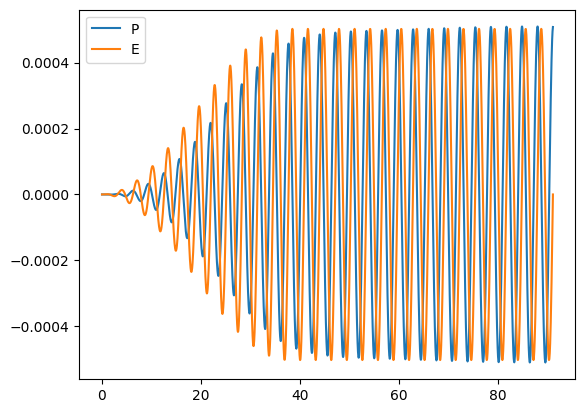

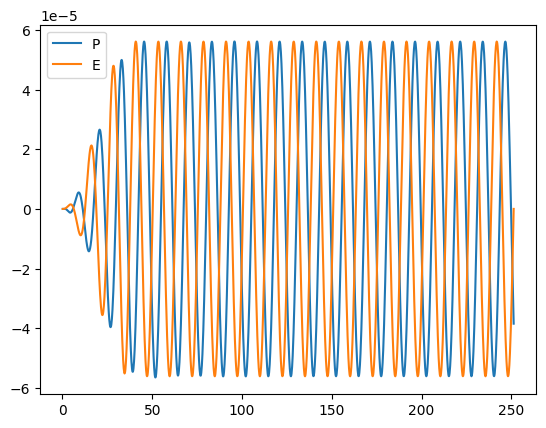

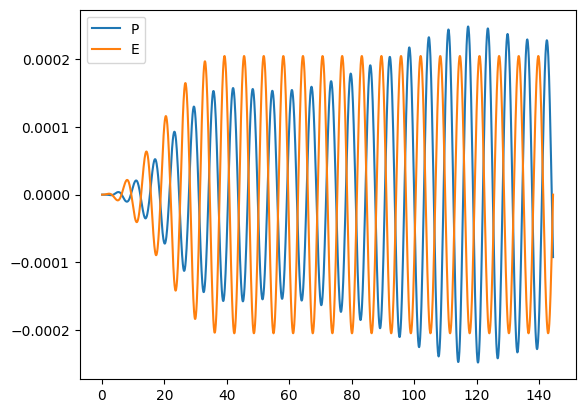

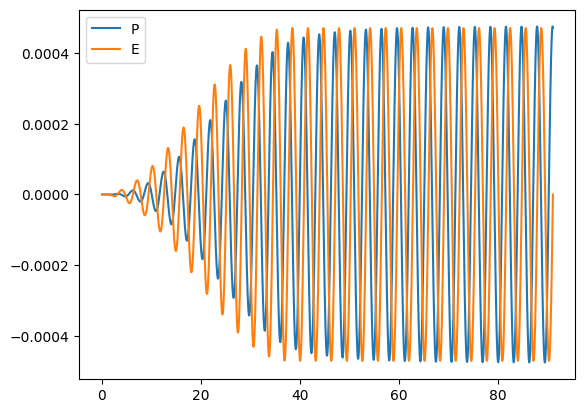

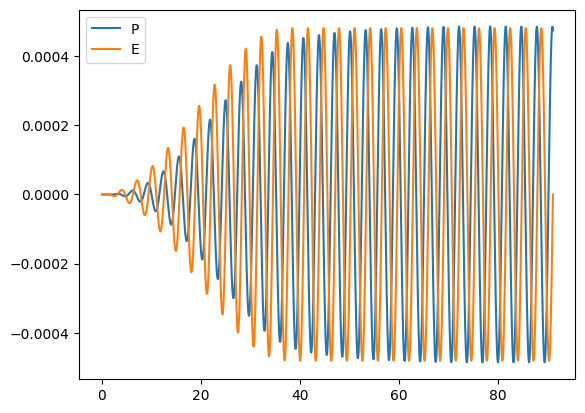

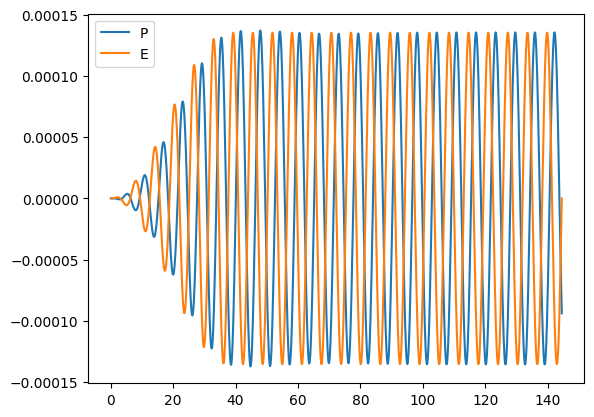

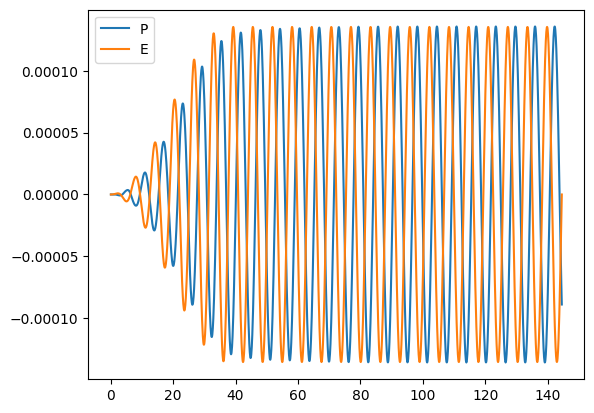

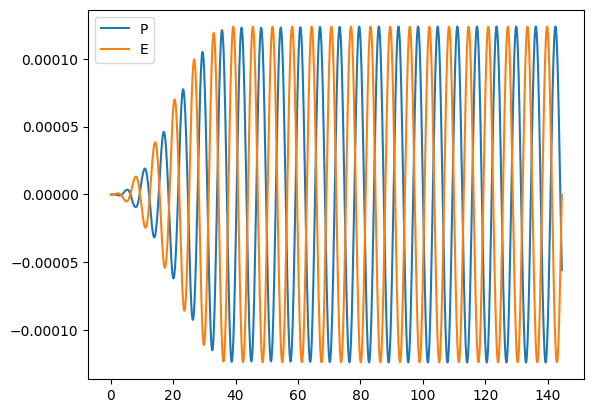

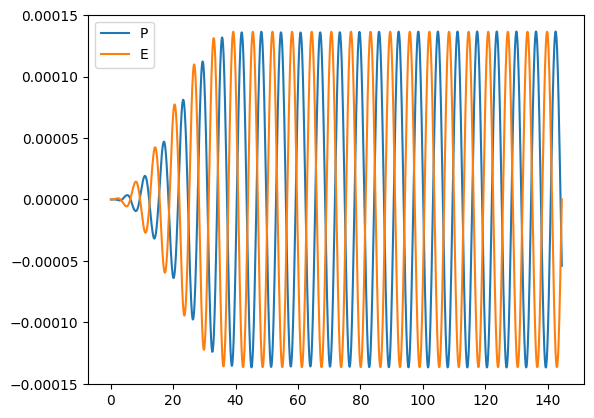

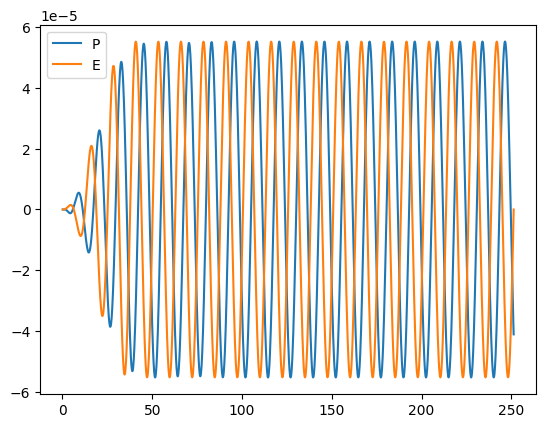

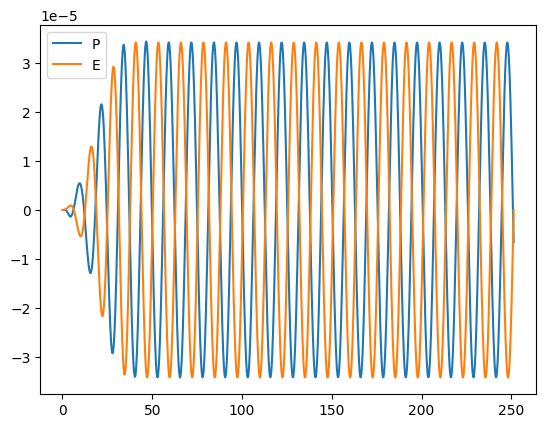

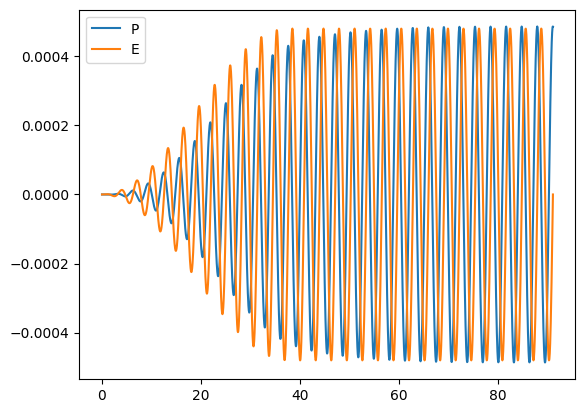

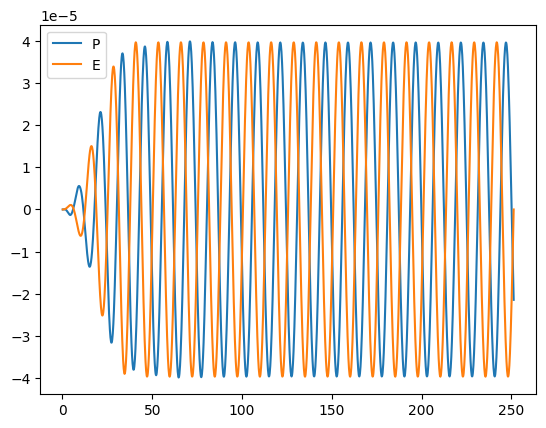

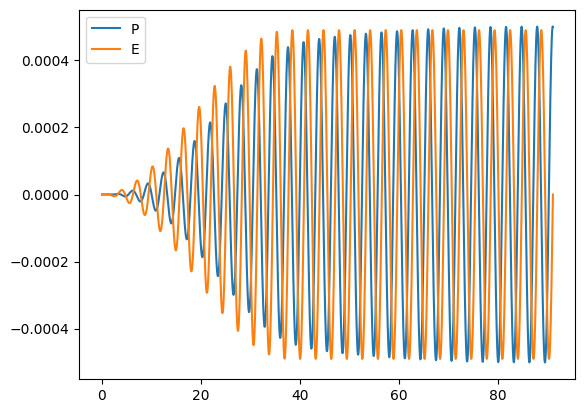

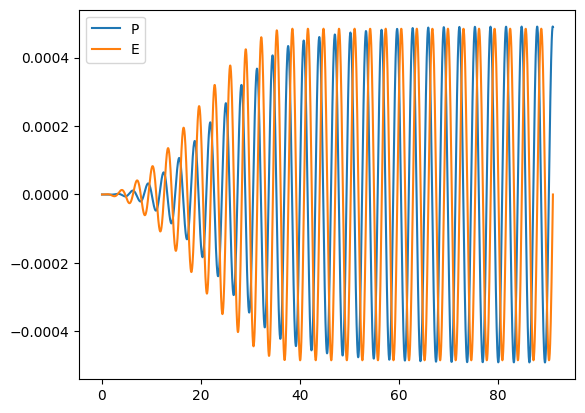

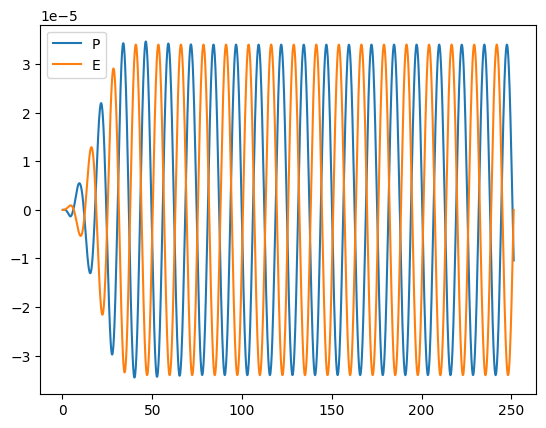

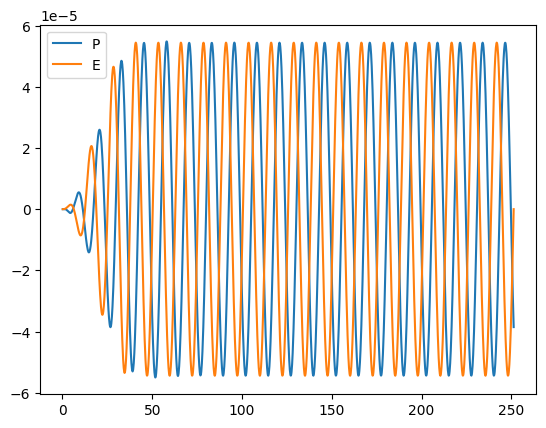

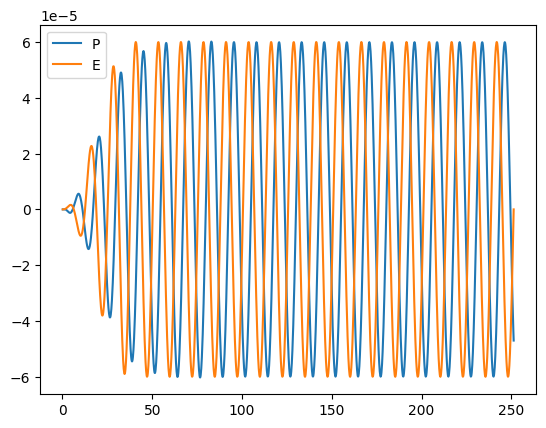

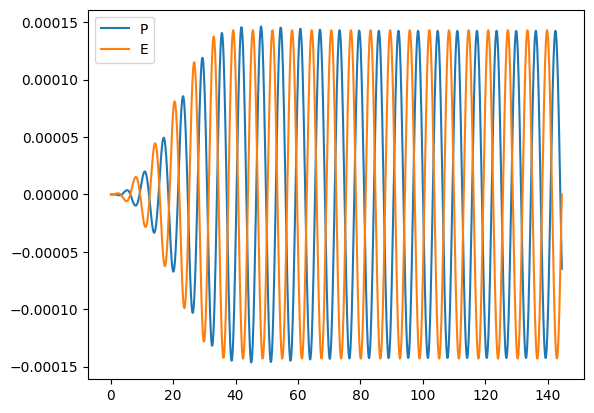

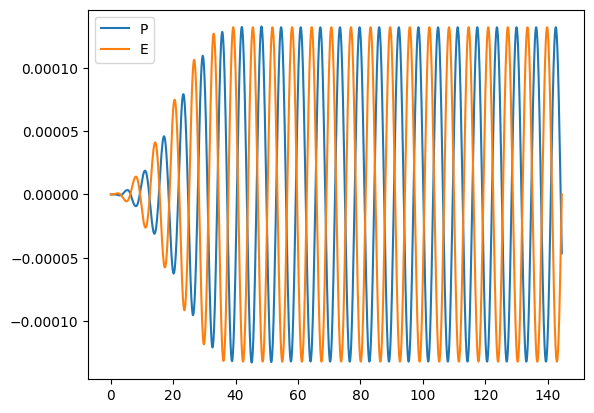

 Lx  Ly  omega  ohc_abs  ohc_angle
 11  20    0.5 0.249479  -2.544989
 11  40    0.5 0.213806  -2.806711
 11  80    0.5 0.215458  -2.923904
 19  20    0.5 0.396509  -2.348481
 19  40    0.5 0.352794  -2.361656
 19  80    0.5 0.348233  -2.433900
 29  20    0.5 0.377115  -2.215946
 29  40    0.5 0.347598  -2.278626
 29  80    0.5 0.341828  -2.330487
 11  20    1.0 0.850265  -2.367959
 11  40    1.0 0.864223  -2.414822
 11  80    1.0 0.850427  -2.416756
 19  20    1.0 0.898920  -2.656682
 19  40    1.0 1.286936  -2.691715
 19  40    1.0 0.857657  -2.725837
 19  80    1.0 0.829203  -2.770766
 29  20    1.0 0.863344  -2.612637
 29  40    1.0 0.777542  -2.663644
 29  80    1.0 0.744171  -2.705085
 11  20    2.0 3.332937   1.599774
 11  40    2.0 3.155657   1.496786
 11  80    2.0 3.084780   1.465118
 19  20    2.0 3.080833   1.683727
 19  40    2.0 3.043137   1.669090
 19  80    2.0 3.020068   1.639692
 29  20    2.0 3.022858   1.801046
 29  40    2.0 2.966037   1.739112
 29  80    2.0 2.954

In [5]:
rows = []
for fname in os.listdir("data"):
    path = os.path.join("data", fname)
    if not fname.endswith(".pkl"): continue

    with open(path, "rb") as fh:
        d = pickle.load(fh)

    if d["substeps"] < 150: continue
    if d["Lx"] > 29: continue

    Trange = 15 * 2 * np.pi / d["omega"]
    # find index where time > Trange
    t_eq = np.searchsorted(d["E_time"], Trange)
    val = ohc(d, t_eq)
    rows.append({
        "Lx": d.get("Lx"),
        "Ly": d.get("Ly"),
        "omega": d.get("omega"),
        "ohc_abs": float(np.abs(val)),
        "ohc_angle": float(np.angle(val)),
        
        #"ohc_Re": float(np.real(val)),
        #"ohc_Im": float(np.imag(val)),
    })

    dt = np.diff(d["E_time"]).mean()

    plt.plot(d["E_time"][1:], np.diff(d["orb_pol_values"][:,0]) / dt, label="P")
    plt.plot(d["E_time"][1:], d["E_amplitude"][1:] * abs(val) / (2*np.pi), label="E")
    plt.legend()
    plt.show()

ohc_df = pd.DataFrame(rows).sort_values(["omega", "Lx", "Ly"], ignore_index=True)
print(ohc_df.to_string(index=False))

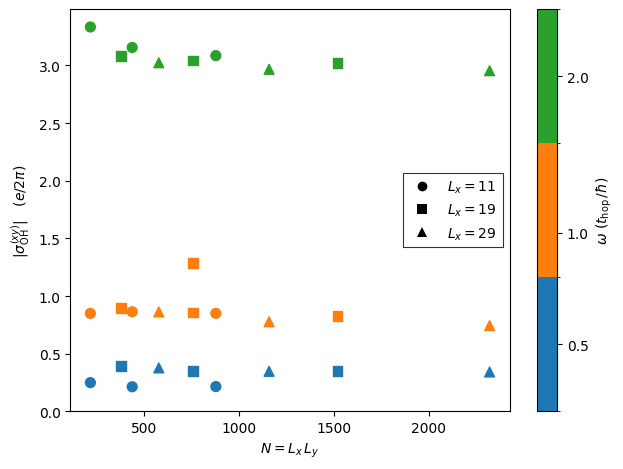

In [6]:
from matplotlib.colors import BoundaryNorm
from matplotlib.cm import ScalarMappable

omegas = np.sort(ohc_df["omega"].unique())
N = len(omegas)

cmap = plt.get_cmap("tab10", 3*N)
if N == 1:
    bounds = np.array([omegas[0] - 0.1, omegas[0] + 0.1])
else:
    mids = (omegas[:-1] + omegas[1:]) / 2
    first = omegas[0] - (mids[0] - omegas[0])
    last = omegas[-1] + (omegas[-1] - mids[-1])
    bounds = np.concatenate(([first], mids, [last]))
norm = BoundaryNorm(bounds, N)

sm = ScalarMappable(norm=norm, cmap=cmap)
sm.set_array([])

fig = plt.gcf()

cb = fig.colorbar(sm, ax=plt.gca(), ticks=omegas)
cb.ax.set_yticklabels([str(o) for o in omegas])
cb.set_label("$\\omega\\ (t_\\mathrm{hop}\\,/\\hbar)$")

# plot ohc_abs vs system size (Lx*Ly), with markers based on Lx and colors based on omega
markers = ['o', 's', '^']
colors = plt.cm.viridis(np.linspace(0, 1, len(ohc_df["Ly"].unique())))

for i, lx in enumerate(sorted(ohc_df["Lx"].unique())):
    lx_data = ohc_df[ohc_df["Lx"] == lx]
    plt.scatter(
        lx_data["Ly"] * lx_data["Lx"],
        lx_data["ohc_abs"],
        marker=markers[i],
        c=lx_data["omega"],
        s=50,
        label=f'Lx={lx}',
        cmap=cmap,
        norm=norm,
        alpha=1
    )

import matplotlib.lines as mlines

s = mlines.Line2D([], [], color='black', marker='s', ls='', label='$L_x=19$', markeredgewidth=0, markersize=7)
o = mlines.Line2D([], [], color='black', marker='o', ls='', label='$L_x=11$', markeredgewidth=0, markersize=7)
v = mlines.Line2D([], [], color='black', marker='^', ls='', label='$L_x=29$', markeredgewidth=0, markersize=7)

legend = plt.legend(handles=[o,s, v], fancybox=False, edgecolor='black')
legend.get_frame().set_linewidth(0.8)

plt.ylim(bottom=0)
plt.xlabel("$N=L_x\\, L_y$")
plt.ylabel("$|\\sigma_\\mathrm{OH}^{(xy)}| \\quad (e/2\\pi)$")
plt.tight_layout()
#plt.savefig("ohc_vs_size.pdf")
plt.show()

# Errors

In [188]:
rows = []
for fname in os.listdir("data_final"):
    path = os.path.join("data_final", fname)
    if not fname.endswith(".pkl"): continue

    with open(path, "rb") as fh:
        d = pickle.load(fh)

    if d["Lx"] > 29: continue

    rows.append({
        "Lx": d.get("Lx"),
        "Ly": d.get("Ly"),
        "omega": d.get("omega"),
        "orb_pol_values": d.get("orb_pol_values")[:, 0],
        "substeps": d.get("substeps"),
    })

ohc_df = pd.DataFrame(rows).sort_values(["omega", "Lx", "Ly"], ignore_index=True)

# loop over unique (Lx, Ly, omega) pairs
for (Lx, Ly, omega), group in ohc_df.groupby(["Lx", "Ly", "omega"]):
    # obtain the orp_pol_values for substeos 50, 100, 150
    substeps = group["substeps"].values[0]
    pol_50 = group[group["substeps"] == 50]["orb_pol_values"]
    pol_100 = group[group["substeps"] == 100]["orb_pol_values"]
    pol_200 = group[group["substeps"] == 200]["orb_pol_values"]
    
    #plt.plot(pol_50.values[0], "k-", label="50 substeps", )
    #plt.plot(pol_100.values[0], "r.", label="100 substeps")
    #plt.plot(pol_200.values[0], "b--", label="200 substeps")
    #plt.title(f"Lx={Lx}, Ly={Ly}, omega={omega}")
    #plt.show()

    # calc rms(200-50), rms(200-100)
    rms_50 = np.sqrt(np.mean((pol_200.values[0] - pol_50.values[0])**2))
    rms_100 = np.sqrt(np.mean((pol_200.values[0] - pol_100.values[0])**2))

    print(rms_50, rms_100)

    #print(f"Lx={Lx}, Ly={Ly}, omega={omega}: RMS50/RMS100={rms_100/rms_50:.3e}")

1.732971e-08 1.5455848e-08
2.8957063e-08 2.6172907e-08
4.3059384e-08 3.4203477e-08
2.2630607e-08 2.1058188e-08
2.5228037e-08 2.060285e-08
4.162705e-08 3.2442838e-08
2.19848e-08 1.8979776e-08
2.500946e-08 1.9767583e-08
4.0363147e-08 2.9141908e-08
2.4823628e-08 2.2847999e-08
3.0576278e-08 2.5037513e-08
5.0308753e-08 4.497006e-08
3.543802e-08 3.018892e-08
2.9566822e-08 2.4731982e-08
4.829845e-08 3.9324807e-08
3.85071e-08 3.4329528e-08
3.059674e-08 2.5627761e-08
5.3203188e-08 4.3430813e-08
2.6657558e-08 2.2908141e-08
3.1582903e-08 2.6426735e-08
4.8267463e-08 3.9343668e-08
2.746865e-08 2.4179425e-08
2.8723306e-08 2.4478952e-08
4.750069e-08 3.9273875e-08
2.9126287e-08 2.541325e-08
2.8217078e-08 2.3934247e-08
4.665105e-08 3.8626563e-08
